In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.special as sf
import matplotlib as mpl
from mycolorpy import colorlist as mcp
from astropy.io import ascii
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
plt.rcParams['font.size'] = 15
from matplotlib import colors


In [3]:
%run Fraunhofer.py

# 11/14

In [5]:

def filter_annulus(screen, A, k_in, k_out):
    """
    amplitude
    k_in, k_out: filter radius in the fourier space
    A = amplitude of error mask"""
    N = screen['N']
    k = screen['kap'] # radius in k space
    
    # white noise
    WN = np.random.normal(0,1,(N,N))
    WN_FT = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(WN)))
    #filter
    cut1 = np.where(k<k_in, 0, 1)
    cut2 = np.where(k>k_out, 0, 1)
    WN_FT_fil = WN_FT*cut1*cut2 # filtered WN in fourier space
    WN_fil = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(WN_FT_fil)))) # filtered WN in real space
    screen['E'] = (1 + A*WN_fil) * screen['E']
    return(WN_FT_fil) #return amplitude
    

def filter_annulus_phase(screen, B, k_in, k_out):
    """phase"""
    N = screen['N']
    k = screen['kap']
    WN = np.random.normal(0,1,(N,N))
    WN_FT = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(WN)))
    cut1 = np.where(k<k_in, 0, 1)
    cut2 = np.where(k>k_out, 0, 1)
    WN_FT_fil = WN_FT*cut1*cut2 # filtered WN in fourier space
    WN_fil = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(WN_FT_fil)))) # filtered WN in real space
    E_complex = screen['E']*np.exp(1j*B*WN_fil) 
    #screen['E'] = np.sqrt(np.real(E_complex**2) + np.imag(E_complex)**2)
    screen['E'] = E_complex
    #print(np.imag(E_complex)[500])
    return(B*WN_fil) 
    

def filter_WN(screen, A, k_in, k_out):
    """
    k_in, k_out: filter radius in the fourier space
    A = amplitude of error mask"""
    N = screen['N']
    k = screen['kap'] # radius in k space
    
    # white noise
    WN = np.random.normal(0,1,(N,N))
    WN_FT = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(WN)))
    #filter
    cut1 = np.where(k<k_in, 0, 1)
    cut2 = np.where(k>k_out, 0, 1)
    WN_FT_fil = WN_FT*cut1*cut2 # filtered WN in fourier space
    WN_fil = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(WN_FT_fil))) # filtered WN in real space
    return(WN_fil)
    
def rms(error_map):
    return np.sqrt(np.mean(error_map**2))

In [48]:
lam = 0.002 #mm wavelength
thetamaxdeg = 5.0
thetamax = thetamaxdeg*np.pi/180.
theta_vec = np.linspace(-thetamax,thetamax,2048) 

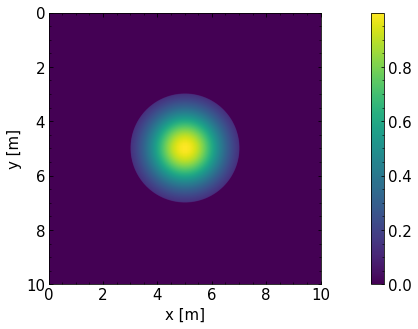

In [49]:
### an unperturbed screen

screen = {}
screen['N'] = 4096
screen['D'] = 10
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, 1.0)
InCircle(screen, center, 2.0)
ScreenFFT(screen)
II0 = Project_I_on_thetagrid(theta_vec,screen,lam) 

plt.imshow(screen['E'],extent=(0,screen['D'],screen['D'],0))
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar()
plt.show()


In [50]:
print(screen['kap'][0].max()) # k_max of our screen
print(2*np.pi/lam * np.sin(np.deg2rad(3))) # three degrees to k_max in our interpolation

1819.8048514696668
164.4182556514292


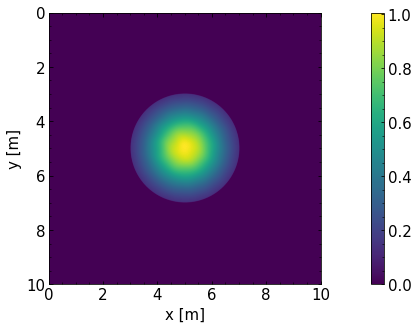

In [51]:
# perturbed screen (amplitude )

screen1 = {}
screen1['N'] = 4096
screen1['D'] = 10
Initialize(screen1)
center = (screen1['D']/2, screen1['D']/2)
MultByGaussian(screen1, center, 1.0)
emap = filter_annulus(screen1, 1.0, 10, 12) # ~ 10 - 12 for degree scale errors 
InCircle(screen1, center, 2.0)
ScreenFFT(screen1)
II1 = Project_I_on_thetagrid(theta_vec,screen1,lam) 
#plt.imshow(emap,interpolation=None)#extent=(0,screen1['D'],screen1['D'],0))
#plt.colorbar()
#plt.xlim(900,1100)
#plt.ylim(900,1100)

plt.show()
plt.imshow(np.real(screen1['E']),extent=(0,screen1['D'],screen1['D'],0))
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
# plt.xlim(3,7)
# plt.ylim(3,7)
plt.show()
#plt.imshow(screen1['E'],extent=(0,screen1['D'],screen1['D'],0))
#plt.colorbar()
#print(rms(emap))
#print(emap.max())


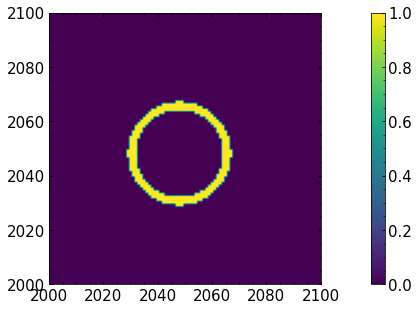

In [58]:
### check the annular noise filter 

k=screen1['kap']
cut1 = np.where(k<10, 0, 1)
cut2 = np.where(k>12, 0, 1)
plt.imshow(cut1*cut2)
plt.xlim(2000, 2100)
plt.ylim(2000, 2100)
plt.colorbar()
plt.show()

Text(0, 0.5, 'degree')

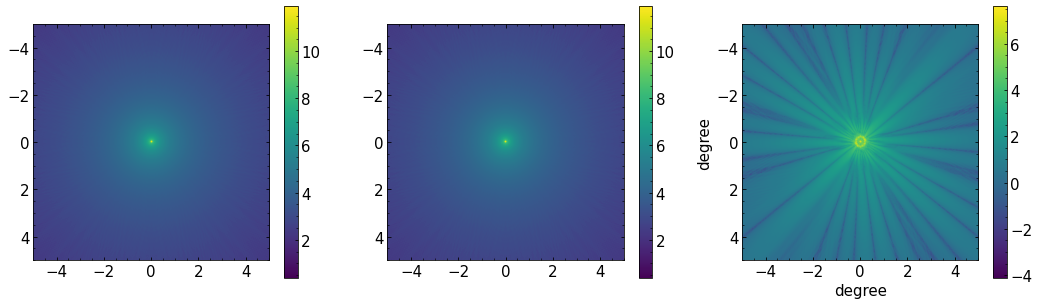

In [59]:
### compare the unperturbed and perturbed screens (amplitude error)

plt.rcParams['figure.figsize'] = [18, 5]
plt.subplot(1,3,1)
plt.imshow(np.log10(II0), interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg]) # unperturbed
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.log10(II1), interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg]) # perturbed
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.log10(np.abs(II0-II1)), interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg]) # difference
plt.colorbar()
plt.xlabel('degree')
plt.ylabel('degree')

#plt.xlim(-1,1)
#plt.ylim(-1,1)
#print(screen['I'].min())

Text(0, 0.5, 'log(I difference)')

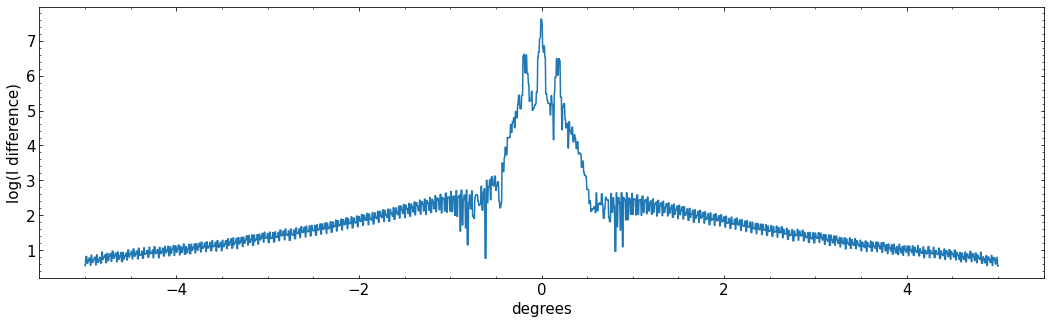

In [60]:
### take a slice and examine the feature
plt.plot(theta_vec*180/np.pi, np.log10(np.abs(II0-II1)[1024]))
plt.xlabel('degrees')
plt.ylabel('log(I difference)')

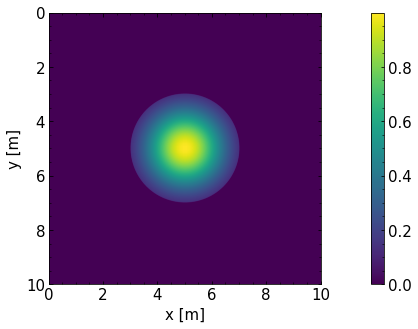

In [70]:
# perturbed screen (phase error)

screen2 = {}
screen2['N'] = 4096
screen2['D'] = 10
Initialize(screen2)
center = (screen2['D']/2, screen2['D']/2)
MultByGaussian(screen2, center, 1.0)
emap = filter_annulus_phase(screen2, 1.0, 10, 12) # ~ 10 - 12 for degree scale errors 
InCircle(screen2, center, 2.0)
ScreenFFT(screen2)
II2 = Project_I_on_thetagrid(theta_vec,screen2,lam) 

plt.show()
plt.imshow(np.real(screen2['E']),extent=(0,screen2['D'],screen2['D'],0))
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

Text(0, 0.5, 'degree')

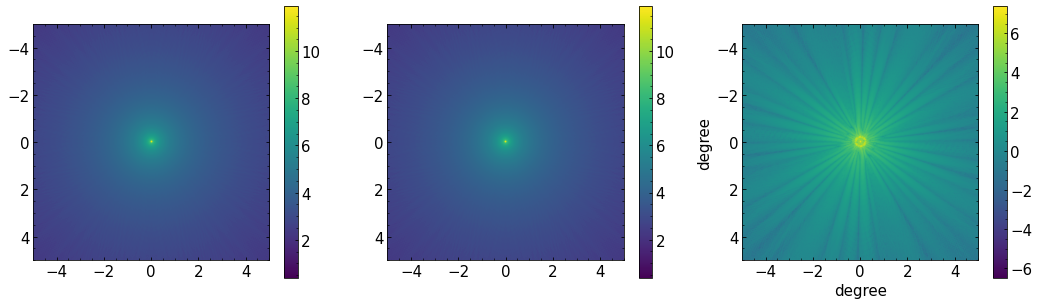

In [74]:
### compare the unperturbed and perturbed screens (phase errors)

plt.rcParams['figure.figsize'] = [18, 5]
plt.subplot(1,3,1)
plt.imshow(np.log10(II0), interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg]) # unperturbed
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.log10(II2), interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg]) # perturbed
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.log10(np.abs(II0-II2)), interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg]) # difference
plt.colorbar()
plt.xlabel('degree')
plt.ylabel('degree')

# plt.xlim(-2,2)
# plt.ylim(-2,2)
#print(screen['I'].min())

## Generate error masks 

white noise in real space -> FT -> annular filter in k space -> iFT -> filtered noise map in real space M(x,y)

25.464790894703256


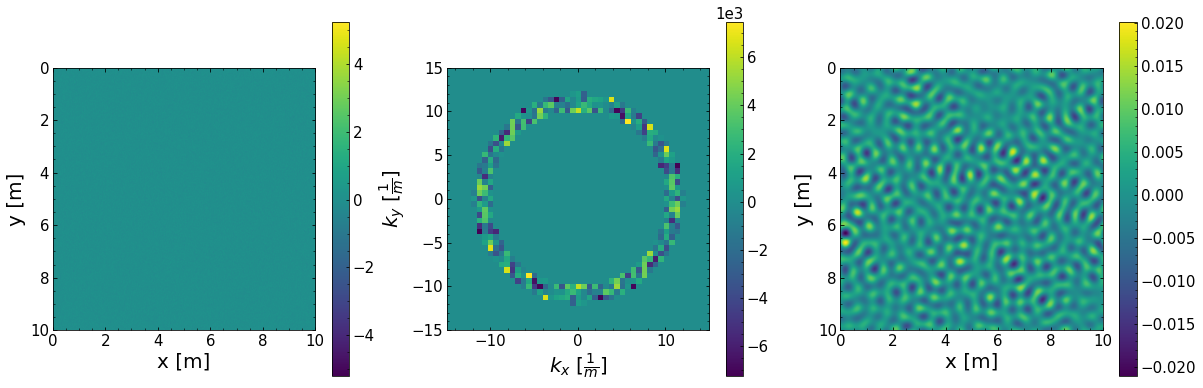

In [63]:
### annulus - k_in=10, k_out=12 for visualization
### a simular one was used in my thesis

N = screen['N']
k = screen['kap'] # radius in k space
print(16/screen['dk']) #k~16
# white noise
WN = np.random.normal(0,1,(N,N))
WN_FT = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(WN)))
#filter
cut1 = np.where(k<10, 0, 1)
cut2 = np.where(k>12, 0, 1)
WN_FT_fil = WN_FT*cut1*cut2 # filtered WN in fourier space
WN_fil = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(WN_FT_fil))) # filtered WN in real space
fig = plt.figure(figsize=(20,6.5))
plt.subplot(1,3,1)
plt.imshow(WN,cmap='viridis', extent=(0,screen['D'],screen['D'],0))
#plt.title('white noise in real space')
plt.xlabel('x [m]', fontsize=20)
plt.ylabel('y [m]', fontsize=20)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.real(WN_FT_fil), cmap='viridis', extent=(screen['kx'].min(),screen['kx'].max(),screen['kx'].max(),screen['kx'].min()))
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
#plt.title('filtered WN in k space')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel(r'$k_x$ [$\frac{1}{m}$]', fontsize=20)
plt.ylabel(r'$k_y$ [$\frac{1}{m}$]', fontsize=20)
#plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.real(WN_fil),cmap='viridis', extent=(0,screen['D'],screen['D'],0))
#plt.title('filtered WN in real space')
plt.xlabel('x [m]', fontsize=20)
plt.ylabel('y [m]', fontsize=20)
plt.colorbar()
#plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Thesis/ErrMap_h.png', bbox_inches='tight', dpi=600)

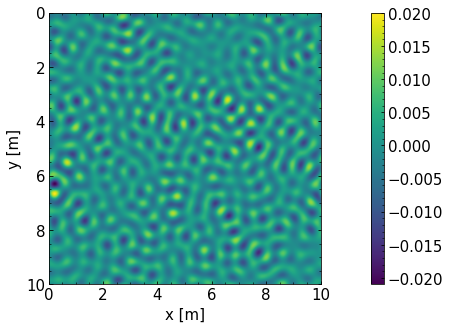

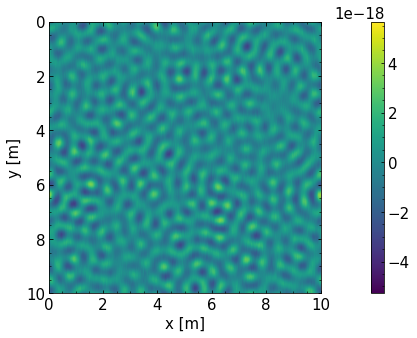

In [65]:
### check real and imaginary components of the filtered noise map in real space 
plt.imshow(np.real(WN_fil),cmap='viridis', extent=(0,screen['D'],screen['D'],0))
#plt.title('filtered WN in real space')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar()
plt.show()
plt.imshow(np.imag(WN_fil),cmap='viridis', extent=(0,screen['D'],screen['D'],0))
#plt.title('filtered WN in real space')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar()
plt.show()

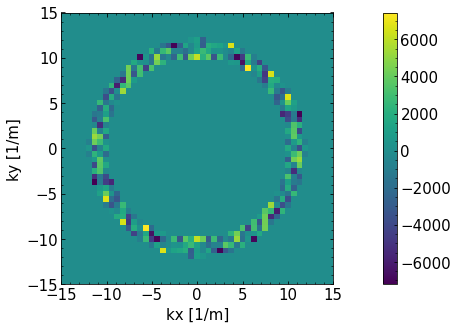

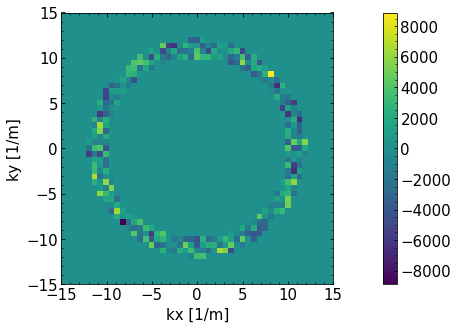

In [67]:
plt.imshow(np.real(WN_FT_fil), cmap='viridis', extent=(screen['kx'].min(),screen['kx'].max(),screen['kx'].max(),screen['kx'].min()))
#plt.title('filtered WN in k space')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel('kx [1/m]')
plt.ylabel('ky [1/m]')
plt.colorbar()
plt.show()
plt.imshow(np.imag(WN_FT_fil), cmap='viridis', extent=(screen['kx'].min(),screen['kx'].max(),screen['kx'].max(),screen['kx'].min()))
#plt.title('filtered WN in k space')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel('kx [1/m]')
plt.ylabel('ky [1/m]')
plt.colorbar()